In [85]:
import numpy as np
import ast
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

In [86]:
# Load CSV
df = pd.read_csv("../data/data.csv")

# Convert stringified list columns
df['genres'] = df['genres'].apply(ast.literal_eval)
df['privacy_types'] = df['privacy_types'].apply(ast.literal_eval)
df['data_categories'] = df['data_categories'].apply(ast.literal_eval)
df['data_types'] = df['data_types'].apply(ast.literal_eval)

In [87]:
# Encode features
X_feats = pd.DataFrame()

# Numeric and boolean features
X_feats['price'] = df['price']
X_feats['size'] = df['size']
X_feats['has_in_app_purchases'] = df['has_in_app_purchases'].astype(int)

In [88]:
# Categorical features: content_rating and country_code
X_feats = pd.concat([
    X_feats,
    pd.get_dummies(df['content_rating'], prefix="rating"),
    pd.get_dummies(df['country_code'], prefix="country")
], axis=1)

# Multi-hot encode genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(df['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb_genres.classes_])
X_feats = pd.concat([X_feats, genres_df], axis=1)

In [89]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_feats)

# Encode target labels (e.g. privacy_types)
mlb_privacy = MultiLabelBinarizer()
y_privacy = mlb_privacy.fit_transform(df['privacy_types'])

In [90]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_privacy, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

In [91]:
class PrivacyPredictor(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, hidden3=64, output_dim=4):
        super(PrivacyPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return self.out(x)

In [ ]:
model = PrivacyPredictor(input_dim=X.shape[1])

# Calculate pos_weight for imbalanced labels
label_counts = y_train.sum(dim=0)
pos_weight = (len(y_train) - label_counts) / (label_counts + 1e-6)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)


Epoch 1/100 — F1 Score: 0.7040
Epoch 2/100 — F1 Score: 0.7210
Epoch 3/100 — F1 Score: 0.7350
Epoch 4/100 — F1 Score: 0.7410
Epoch 5/100 — F1 Score: 0.7474
Epoch 6/100 — F1 Score: 0.7543
Epoch 7/100 — F1 Score: 0.7496
Epoch 8/100 — F1 Score: 0.7582
Epoch 9/100 — F1 Score: 0.7593
Epoch 10/100 — F1 Score: 0.7610
Epoch 11/100 — F1 Score: 0.7627
Epoch 12/100 — F1 Score: 0.7607
Epoch 13/100 — F1 Score: 0.7630
Epoch 14/100 — F1 Score: 0.7628
Epoch 15/100 — F1 Score: 0.7611
Epoch 16/100 — F1 Score: 0.7632
Epoch 17/100 — F1 Score: 0.7622
Epoch 18/100 — F1 Score: 0.7658
Epoch 19/100 — F1 Score: 0.7654
Epoch 20/100 — F1 Score: 0.7656
Epoch 21/100 — F1 Score: 0.7644
Epoch 22/100 — F1 Score: 0.7645
Epoch 23/100 — F1 Score: 0.7668
Epoch 24/100 — F1 Score: 0.7650
Epoch 25/100 — F1 Score: 0.7650
Epoch 26/100 — F1 Score: 0.7673
Epoch 27/100 — F1 Score: 0.7661
Epoch 28/100 — F1 Score: 0.7660
Epoch 29/100 — F1 Score: 0.7648
Epoch 30/100 — F1 Score: 0.7649
Epoch 31/100 — F1 Score: 0.7661
Epoch 32/100 — F1

In [ ]:
EPOCHS = 100
best_f1 = 0
best_model = None
f1_scores = []

# Early stopping setup
early_stop_patience = 7
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    all_preds, all_true, all_probs = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)

    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}/{EPOCHS} — F1 Score: {f1:.4f}")

    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model = model.state_dict()
        early_stop_counter = 0  # reset counter if improved
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stopping counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Restore best model
model.load_state_dict(best_model)


In [93]:
model.load_state_dict(best_model)

# Apply fixed threshold (e.g. 0.5) to all predictions
final_preds = (all_probs > 0.5).astype(int)

# Classification report
print(classification_report(
    all_true, final_preds,
    target_names=mlb_privacy.classes_,
    zero_division=0
))


                        precision    recall  f1-score   support

    Data Linked to You       0.70      0.87      0.78       890
    Data Not Collected       0.62      0.90      0.74       555
Data Not Linked to You       0.72      0.77      0.74      1124
Data Used to Track You       0.76      0.87      0.81       839

             micro avg       0.70      0.84      0.77      3408
             macro avg       0.70      0.85      0.77      3408
          weighted avg       0.71      0.84      0.77      3408
           samples avg       0.68      0.80      0.72      3408



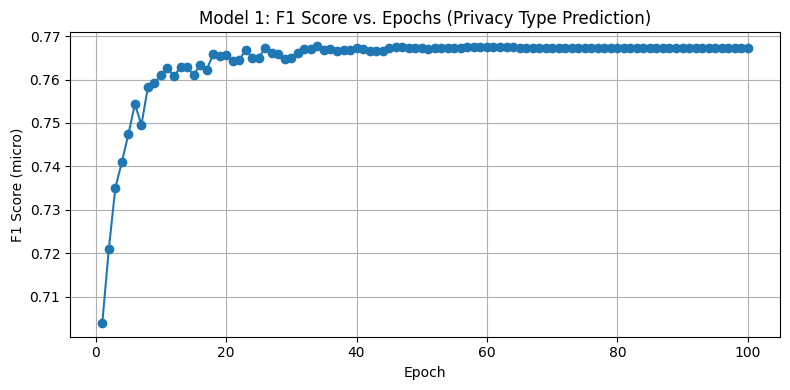

In [94]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
plt.title("Model 1: F1 Score vs. Epochs (Privacy Type Prediction)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (micro)")
plt.grid(True)
plt.tight_layout()
plt.show()


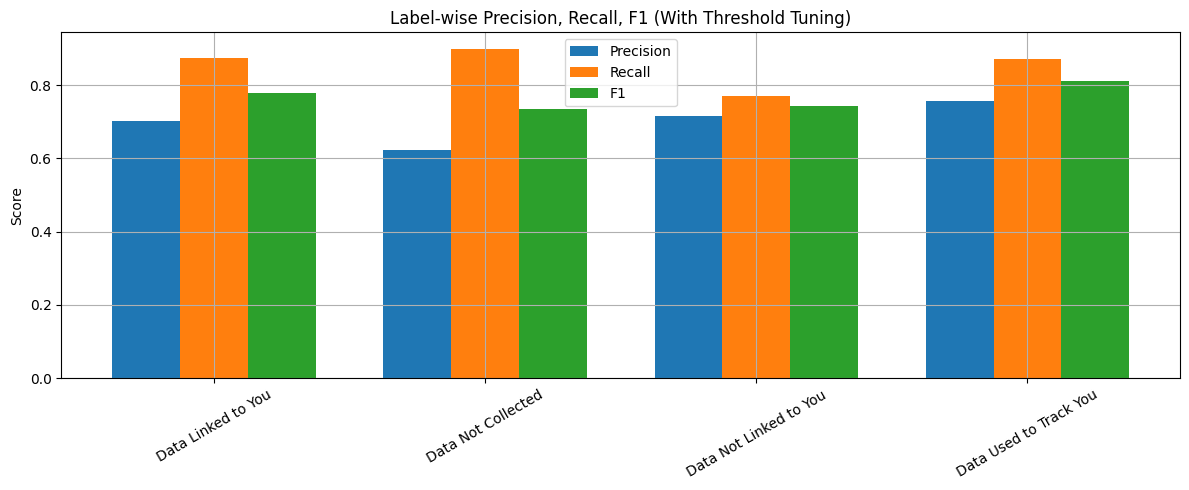

In [95]:
# %%
# Plot label-wise precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_true, final_preds, zero_division=0)
labels = mlb_privacy.classes_

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')

plt.xticks(x, labels, rotation=30)
plt.ylabel("Score")
plt.title("Label-wise Precision, Recall, F1 (With Threshold Tuning)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [96]:
# Per-sample F1 scores for your model
f1_yours_sample = [
    f1_score(all_true[i], final_preds[i], zero_division=0)
    for i in range(len(all_true))
]

# Baseline average (e.g., 65%)
baseline_f1 = 0.65
f1_baseline_sample = [baseline_f1] * len(all_true)

# Run Wilcoxon test
stat, p_f1 = wilcoxon(f1_yours_sample, f1_baseline_sample, alternative='greater')

print(f"Per-sample F1 (mean): {np.mean(f1_yours_sample):.4f}")
print(f"Wilcoxon signed-rank test p-value (F1 > {baseline_f1}): {p_f1:.6f}")


Per-sample F1 (mean): 0.7221
Wilcoxon signed-rank test p-value (F1 > 0.65): 0.000000
